In [1]:
import datetime
import matplotlib.pyplot as plt
import pyaurorax

aurorax = pyaurorax.PyAuroraX()

# TREx-ATM Forward Calculation

TREx-ATM is a time-dependent Aurora Transport Model (ATM), designed to leverage and support TREx optical data. TREx-ATM uses the two-stream electron transport code embedded in the GLOW model (Solomon et al., 1988) with ambipolar diffusion to compute the electron transport. It has additional capacity to compute impact ionization, secondary electron production, and impact excitation of neutrals (height resolved). Use of the TREx-ATM model should cite:

- Liang, J., Donovan, E., Jackel, B., Spanswick, E., & Gillies, M. (2016). On the 630nmred-linepulsating aurora: Red-line emission geospace observatory observations and model simulations. Journal of Geophysical Research: Space Physics, 121, 7988–8012. https://doi.org/10.1002/2016JA022901 
- Liang, J., Yang, B., Donovan, E., Burchill, J., & Knudsen, D. (2017). Ionospheric electron heating associated with pulsating auroras: A Swarm survey and model simulation. Journal of Geophysical Research: Space Physics, 122, 8781–8807. https://doi.org/10.1002/2017JA024127

NOTE: As of June 2025, ATM version "2.0" is now the default model version for the forward calculation method. If you want to use the version '1.0', simply adjust the `atm_model_version` parameter.

## Perform a basic 'forward' calculation

First will show how to do a basic request, and plot the results.

Requests take a series of input parameters. Some parameters are required, and some are optional with default values that will be set if they are not supplied. The following request we'll be performing utilizes all default values for the optional parameter (marked as such with a comment on that line).

More details on inputs and outputs [in the `forward()` function documentation](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax/models/atm/index.html#pyaurorax.models.atm.ATMManager.forward).

<small>
Input notes:

- By default requests are cached. Use the 'no_cache' parameter to disable this functionality
- Latitude and longitude are to be in geodetic coordinates (-90 to 90 lat, -180 to 180 lon)
- Timestamp
  - timestamp is expected to be in UTC, and is valid for any value up to the end of the previous day
  - the 'Z' character at the end of the timestamp is optional, and will be ignored if it is supplied
- Spectral shapes
  - If the maxwellian_energy_flux is not 0, then maxwellian_characteristic_energy will be used. If
    maxwellian_characteristic_energy is not specified, then the default will be used.
  - If the gaussian_energy_flux is not 0, then gaussian_peak_energy and gaussian_spectral_width will be
    used. If these two values are not specified, then the defaults will be used. 
  - If kappa_energy_flux is not 0, then kappa_mean_energy and kappa_k_index will be used. If these two 
    values are not specified, then the defaults will be used.
  - If exponential_energy_flux is not 0, then exponential_characteristic_energy and exponential_starting_energy
    will be used. If these two values are not specified, then the defaults will be used.
  - **IMPORTANT**: All the above spectral shapes are super-imposable except exponential. The exponential spectrum 
    should be only be used for high-energy tail and, starting from E0 (proton_starting_energy), will override any 
    other spectral specification.
- If proton_energy_flux is not 0, then proton_characteristic_energy will be used. If the 
  proton_characteristic_energy is not specified, then the default will be used.
- The ATM model is 1D and time-independent. However, the optional parameters timescale_auroral and 
  timescale_transport provide limited support for time-dependent and transport process.
    - timescale_auroral (T0) is the duration of the precipitation; default value is 600 sec
    - timescale_transport is defined by L/v0, in which L is the dimension of the auroral structure, 
      and v0 is the cross-structure drift speed. Default value is 600 sec.
    - the model quasi-analytically solves the continuity equation under a square input (with time 
      duration T0 and spatial width L) input of precipitation. The initial/boundary conditions are 
      given by IRI. The output yields the mean density/VER over [0-L] at time T0.
- **NOTE**: proton precipitation is presently only for ionization rate and density calculations. Proton auroras are 
  not nominal TREx characteristics and currently not computed in this version of the model.
- Units and defaults
  - maxwellian total energy flux: erg/cm2/s, default is 10 
  - maxwellian characteristic energy: eV, default is 5000 
  - gaussian total energy flux: erg/cm2/s, default is 0 (indicating all gaussian parameters are disabled) 
  - gaussian peak energy: eV, default is 1000
  - gaussian spectral width: eV, default is 100
  - kappa total energy flux: erg/cm2/s, default is 0 (indicating all kappa parameters are disabled) 
  - kappa mean energy: eV, default is 30000
  - kappa k-index: no unit, default is 5
  - exponential total energy flux: erg/cm2/s, default is 0 (indicating all exponential parameters are disabled) 
  - exponential characteristic energy: eV, default is 50000
  - exponential starting energy: eV, default is 50000
  - proton total energy flux: erg/cm2/s, default is 0 (indicating all proton parameters are disabled) 
  - proton characteristic energy: eV, default is 10000
  - d-region flag: defaults to false
  - custom spectrum (precipitation) 
    - energy in eV, flux in 1/cm2/s/eV 
    - energy and flux arrays must be the same length 
    - users are responsible for fully covering the energy range of interest in the provided spectrum. The model 
      only performs interpolation, not extrapolation.
  - custom neutral profile 
    - altitude in km, density in cm^-3, temperature in K. 
    - users are responsible for fully covering the altitude range of interest in the provided profile (80-800 km 
      if d_region_flag=0, or 50-500 km if d_region_flag=1). The model only performs interpolation, not extrapolation.
  - nrlmsis_model_version: valid values are "00" and "2.0", default is "2.0"
  - oxygen_correction_factor: default is 1.0
  - timescale_auroral: seconds, default is 600 
  - timescale_transport: seconds, default is 600 
</small>

<small>
Output notes:

- output parameter of the request are toggles the enable/disable each field's inclusion in the response
- all output parameters are false by default
- altitude: kilometers
- emission data: 1-D arrays -- volume emission rate, 1/cm^3/s
- plasma electron density: 1-D array, cm^-3
- plasma O2+ density: 1-D array, cm^-3
- plasma NO+ density: 1-D array, cm^-3
- plasma O+ density: 1-D array, cm^-3
- plasma ionisation rate: 1-D array, 1/cm^3/s
- plasma electron temperature: 1-D array, K
- plasma ion temperature: 1-D array, K
- plasma peterson conductivity: 1-D array, S/m
- plasma hall conductivity: 1-D array, S/m
- neutral O2 density: 1-D array, cm^-3
- neutral O density: 1-D array, cm^-3
- neutral N2 density: 1-D array, cm^-3
- neutral N density: 1-D array, cm^-3
- neutral temperature: 1-D array, K
- production_rate_o2plus: 1-D array, 1/cm^3/s
- production_rate_oplus: 1-D array, 1/cm^3/s
- production_rate_oneg: 1-D array, 1/cm^3/s
- production_rate_o: 1-D array, 1/cm^3/s
- production_rate_nplus: 1-D array, 1/cm^3/s
- production_rate_n2plus: 1-D array, 1/cm^3/s
- production_rate_n: 1-D array, 1/cm^3/s
- production_rate_n2d: 1-D array, 1/cm^3/s
</small>

ATM requests require that users toggle ON outputs they wish to have returned. This allows you to get back only what you want. This mechanism is controlled by the `ATMForwardOutputFlags()` class that must be instantiated before making an ATM calculation.

As part of this class, there are helper functions that toggle ON or OFF all outputs, and toggle on common groups.

In [2]:
# set up our request
#
# all output parameters are default to False. Here we initialize
# the output flags we want to get
output = pyaurorax.models.ATMForwardOutputFlags()  # initialize output flags, all will be False by default
output.enable_only_height_integrated_rayleighs()  # enable all height-integrated Rayleighs values
output.altitudes = True  # enable altitudes
output.emission_5577 = True  # enable the 5577nm emission

# set the location (Calgary-ish)
#
# NOTE: ATM forward calculations can be performed
# for any latitude or longitude
latitude = 51.04
longitude = -114.5

# set the timestamp to UT06 of the previous day
#
# NOTE: ATM forward calculations can be performed for any date up
# to the end of the previous day. It is expected to be in UTC time,
# and any timezone data will be ignored.
timestamp = datetime.datetime(2025, 1, 1, 6, 0, 0)

In [3]:
# perform the calculation
result = aurorax.models.atm.forward(timestamp, latitude, longitude, output)

# view the output
#
# we use handy print method for the results
result.pretty_print()

ATMForwardResult:
  altitudes                            : array([ 80. ,  81. ,  82. ,  83. ,  84. ,  85. ,  86. ,  87. ...])
  emission_1304                        : None
  emission_1356                        : None
  emission_4278                        : None
  emission_5577                        : array([3.51657160e-04, 2.20157579e-03, 2.79500801e-02, 3.347 ...])
  emission_6300                        : None
  emission_8446                        : None
  emission_lbh                         : None
  height_integrated_rayleighs_1304     : 2367.268697
  height_integrated_rayleighs_1356     : 415.737561
  height_integrated_rayleighs_4278     : 2440.129461
  height_integrated_rayleighs_5577     : 18904.221920
  height_integrated_rayleighs_6300     : 298.812248
  height_integrated_rayleighs_8446     : 857.644156
  height_integrated_rayleighs_lbh      : 8611.721333
  neutral_n2_density                   : None
  neutral_n_density                    : None
  neutral_o2_density         

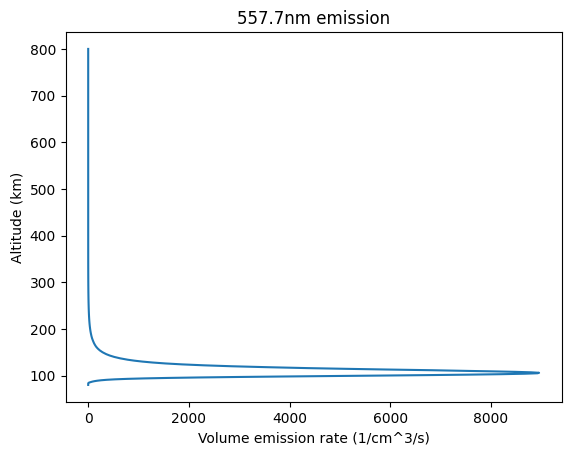

In [4]:
# plot the 557.7nm emission data
plt.title("557.7nm emission")
plt.xlabel("Volume emission rate (1/cm^3/s)")
plt.ylabel("Altitude (km)")
plt.plot(result.emission_5577, result.altitudes)
plt.show()

## Forward calculation and include all output parameters

You can also do a request and specify the output flags to return everything that the ATM 'forward' endpoint has to offer. Below, we're going to do that and plot all data.

In [5]:
# set up params
timestamp = datetime.datetime(2021, 11, 4, 6, 0, 0)
latitude = 58.227808
longitude = -103.680631

# set output flags
output = pyaurorax.models.ATMForwardOutputFlags()
output.set_all_true()

# run model
result = aurorax.models.atm.forward(timestamp, latitude, longitude, output)

# show results
result.pretty_print()

ATMForwardResult:
  altitudes                            : array([ 80. ,  81. ,  82. ,  83. ,  84. ,  85. ,  86. ,  87. ...])
  emission_1304                        : array([7.89980822e-06, 1.56722490e-05, 1.49829284e-04, 1.078 ...])
  emission_1356                        : array([1.28244392e-06, 2.68324652e-06, 2.56772291e-05, 1.848 ...])
  emission_4278                        : array([6.48896545e-02, 4.80853245e-02, 1.74100056e-01, 4.716 ...])
  emission_5577                        : array([3.40655737e-04, 1.30077580e-03, 1.50082102e-02, 1.655 ...])
  emission_6300                        : array([1.02023273e-06, 9.47400451e-07, 4.05005540e-06, 1.350 ...])
  emission_8446                        : array([2.83339682e-06, 5.66904328e-06, 5.42227499e-05, 3.902 ...])
  emission_lbh                         : array([2.02362224e-01, 1.70066178e-01, 6.15893126e-01, 1.668 ...])
  height_integrated_rayleighs_1304     : 1419.193521
  height_integrated_rayleighs_1356     : 248.499309
  height_inte

Height-integrated Rayleighs:
  427.8nm:  2495.31 R
  557.7nm:  16509.21 R
  630.0nm:  241.67 R
  844.6nm:  516.33 R
  LBH:      8842.00 R
  130.4nm:  1419.19 R
  135.6nm:  248.50 R


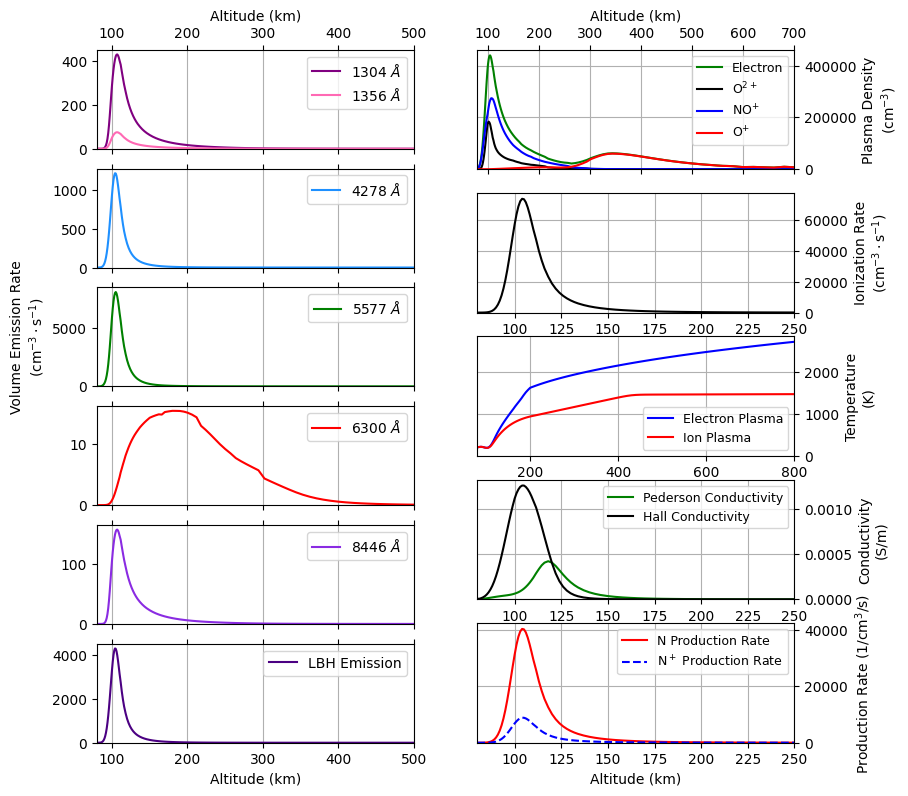

In [6]:
# now let's have a closer look at everything we got back
#
# print all height-integrated Rayleighs data
print("""Height-integrated Rayleighs:
  427.8nm:  %.02f R
  557.7nm:  %.02f R
  630.0nm:  %.02f R
  844.6nm:  %.02f R
  LBH:      %.02f R
  130.4nm:  %.02f R
  135.6nm:  %.02f R""" % (result.height_integrated_rayleighs_4278, result.height_integrated_rayleighs_5577, result.height_integrated_rayleighs_6300,
                          result.height_integrated_rayleighs_8446, result.height_integrated_rayleighs_lbh, result.height_integrated_rayleighs_1304,
                          result.height_integrated_rayleighs_1356))

# plot the emission, plasma, and neutral data
#
# we'll do this all in one plot, but made up from many subplots
alt = result.altitudes
fig = plt.figure(figsize=(9, 9))

# plot all the emissions as a column of subplots
#
# 1304 A & 1356 A emission
ax1 = fig.add_subplot(6, 2, 1)
ax1.plot(alt, result.emission_1304, label=r"1304 $\AA$", color="purple")
ax1.plot(alt, result.emission_1356, label=r"1356 $\AA$", color="hotpink")
ax1.legend()
ax1.set_xlim(80, 500)
ax1.set_ylim(bottom=0)
ax1.grid(axis="x")
ax1.set_xlabel("Altitude (km)", va="bottom")
ax1.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax1.xaxis.set_label_position("top")

# blueline emission
ax2 = fig.add_subplot(6, 2, 3)
ax2.plot(alt, result.emission_4278, label=r"4278 $\AA$", color="dodgerblue")
ax2.legend()
ax2.set_xlim(80, 500)
ax2.set_ylim(bottom=0)
ax2.grid(axis="x")
ax2.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# greenline emission
ax3 = fig.add_subplot(6, 2, 5)
ax3.plot(alt, result.emission_5577, label=r"5577 $\AA$", color="green")
ax3.legend()
ax3.set_xlim(80, 500)
ax3.set_ylim(bottom=0)
ax3.grid(axis="x")
ax3.set_ylabel("Volume Emission Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax3.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# redline emission
ax4 = fig.add_subplot(6, 2, 7)
ax4.plot(alt, result.emission_6300, label=r"6300 $\AA$", color="red")
ax4.legend()
ax4.set_xlim(80, 500)
ax4.set_ylim(bottom=0)
ax4.grid(axis="x")
ax4.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# near-infrared 8446 A emission
ax5 = fig.add_subplot(6, 2, 9)
ax5.plot(alt, result.emission_8446, label=r"8446 $\AA$", color="blueviolet")
ax5.legend()
ax5.set_xlim(80, 500)
ax5.set_ylim(bottom=0)
ax5.grid(axis="x")
ax5.tick_params(axis="x", bottom=True, top=True, labelbottom=False)

# Lyman-Birge-Hopfield emission
ax6 = fig.add_subplot(6, 2, 11)
ax6.plot(alt, result.emission_lbh, label="LBH Emission", color="indigo")
ax6.legend()
ax6.set_xlim(80, 500)
ax6.set_ylim(bottom=0)
ax6.grid(axis="x")
ax6.set_xlabel("Altitude (km)")
ax6.tick_params(axis="x", bottom=True, top=True)

# plot the plasma data as a second column of subplots
#
# plasma density
ax7 = fig.add_subplot(5, 2, 2)
ax7.plot(alt, result.plasma_electron_density, label="Electron", color="green")
ax7.plot(alt, result.plasma_o2plus_density, label="O$^{2+}$", color="black")
ax7.plot(alt, result.plasma_noplus_density, label="NO$^{+}$", color="blue")
ax7.plot(alt, result.plasma_oplus_density, label="O$^{+}$", color="red")
ax7.grid()
ax7.set_ylabel("Plasma Density\n(cm$^{-3}$)")
ax7.legend(fontsize=9)
ax7.set_xlim(80, 700)
ax7.set_ylim(bottom=0)
ax7.tick_params(axis="x", bottom=True, top=True, labeltop=True, labelbottom=False)
ax7.set_xlabel("Altitude (km)")
ax7.xaxis.set_label_position("top")
ax7.yaxis.set_label_position("right")
ax7.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma ionisation rate
ax8 = fig.add_subplot(5, 2, 4)
ax8.plot(alt, result.plasma_ionisation_rate, color="black")
ax8.grid()
ax8.set_ylabel("Ionization Rate\n(cm$^{-3} \cdot $s$^{-1}$)")
ax8.set_xlim(80, 250)
ax8.set_ylim(bottom=0)
ax8.yaxis.set_label_position("right")
ax8.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma temperatures
ax9 = fig.add_subplot(5, 2, 6)
ax9.plot(alt, result.plasma_electron_temperature, label="Electron Plasma", color="blue")
ax9.plot(alt, result.plasma_ion_temperature, label="Ion Plasma", color="red")
ax9.grid()
ax9.legend(fontsize=9)
ax9.set_ylabel("Temperature\n(K)")
ax9.set_xlim(80, 800)
ax9.set_ylim(bottom=0)
ax9.yaxis.set_label_position("right")
ax9.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# plasma conductivities
ax10 = fig.add_subplot(5, 2, 8)
ax10.plot(alt, result.plasma_pederson_conductivity, label="Pederson Conductivity", color="green")
ax10.plot(alt, result.plasma_hall_conductivity, label="Hall Conductivity", color="black")
ax10.grid()
ax10.legend(fontsize=9)
ax10.set_ylabel("Conductivity\n(S/m)")
ax10.set_xlim(80, 250)
ax10.set_ylim(bottom=0)
ax10.set_xlabel("Altitude (km)")
ax10.yaxis.set_label_position("right")
ax10.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# some production rates
ax10 = fig.add_subplot(5, 2, 10)
ax10.plot(alt, result.production_rate_n, label="N Production Rate", color="red")
ax10.plot(alt, result.production_rate_nplus, label="N$^+$ Production Rate", color="blue", linestyle="--")
ax10.grid()
ax10.legend(fontsize=9)
ax10.set_ylabel("Production Rate (1/cm$^3$/s)")
ax10.set_xlim(80, 250)
ax10.set_ylim(bottom=0)
ax10.set_xlabel("Altitude (km)")
ax10.yaxis.set_label_position("right")
ax10.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)

# render the plot
plt.show()

Note that the production rate plot only includes the N and N+ values. There are several more that are available for plotting.